This notebook demonstrates how train a Variational Autoencoder (VAE). on the MNIST dataset. A VAE is a probabilistic take on the autoencoder, a model which takes high dimensional input data compress it into a smaller representation. Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a probability distribution, such as the mean and variance of a Gaussian. This approach produces a continuous, structured latent space, which is useful for image generation.

In [ ]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


Choseing batch_size Epoch Input_shape Output_Shape Latent_Shape (dim for mean and derivative that encoder produce)

In [ ]:
original_dim = 784       # mnist images are of size 28*28=784
batch_size = 100         #size of batches
latent_dim = 2           #latent space size i.e dimension of mean and standard_deviation
intermediate_dim = 256   #intermediate dimension size
epochs = 50              #no of epochs
epsilon_std = 1.0        #parameter which helps in sampling from latent space z

Encoder Part
1 Dense Layer
2 Dense Layer for finding mean and variance

In [ ]:
x = Input(shape=(original_dim,))                     # placeholder for input image
h = Dense(intermediate_dim, activation='relu')(x)    #First layer of encoder is a fully connected layer
z_mean = Dense(latent_dim)(h)                        # fully connected layer which calculates value for latent dimension mean z_mean
z_log_var = Dense(latent_dim)(h)                     # fully connected layer which calculates value for latent dimension std_deviation z_log_var

Creating a new layer to sample input from mean and variance of encoder for Decoding

In [ ]:
# Sampling function which produces a sample using the mean and std_deviation for the decoder to decode
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean = 0, stddev = epsilon_std)
    return z_mean + K.exp(z_log_var/2) * epsilon

In [ ]:
#  Lambda wraps arbitrary expression as a Layer object. This serves to be an input to the decoder.
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean,z_log_var])  # https://keras.io/layers/core/#lambda

Decoder Paer inclding 3 Dense Layer with RELU and SIGNMOID

In [ ]:
# Decoder Part
decoder_h = Dense(intermediate_dim, activation='relu')      #instantiating these layers as these will be needed further for predicting output from latent variables.
decoder_mean = Dense(original_dim, activation='sigmoid')    #instantiating these layers as these will be needed further for predicting output from latent variables.
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

Creating VAE model AND Encoder model to predict inputs after training and Creating Decoder mode

In [ ]:
# Creating a VAE model
vae = Model(x, x_decoded_mean)

#Creating an encoder model
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)

# Creating a decoder model
generator = Model(decoder_input, _x_decoded_mean)

LOSS function of Binary Crossentropy and a parameter to find difrence between encoded an actual value of its input

In [ ]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)                # reconstruction loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)    #Kl divergence loss, this meaures the difference between the current enocded value(latent space) with the actual value. This should be as low as possible.
    return K.mean(xent_loss + kl_loss)

vae.compile(optimizer = 'rmsprop',loss = vae_loss)
vae.summary()       #structure of the whole variational autoencoder

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
____________________________________________________________________________________________

Load DAta and Preproses them and reshape them AfterWArd

In [ ]:
# load training as well as test data
(x_train,y_train),(x_test,y_test) = mnist.load_data()

# print("Training Data Shape X:", x_train.shape," y: ", y_train.shape)
# print("Test Data Shape X:", x_test.shape," y: ", y_test.shape)

# Normalizing the values of training and test set
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

# converting data into specific shape so that it could be fed into the model i.e flattening each example from (28,28) to (784) size 
x_train = x_train.reshape((len(x_train),np.prod(x_train.shape[1:])))

x_test = x_test.reshape((len(x_test),np.prod(x_test.shape[1:])))

11493376/11490434 [==============================] - 0s 0us/step


FIT VAE model for 50 epoch

In [ ]:
# training for 50 epochs
vae.fit(x_train,x_train,
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 87us/step - loss: 190.4613 - val_loss: 173.6104
Epoch 2/50
60000/60000 [==============================] - 4s 60us/step - loss: 170.7583 - val_loss: 168.5863
Epoch 3/50
60000/60000 [==============================] - 4s 62us/step - loss: 166.9695 - val_loss: 165.5943
Epoch 4/50
60000/60000 [==============================] - 4s 61us/step - loss: 164.7535 - val_loss: 164.1013
Epoch 5/50
60000/60000 [==============================] - 3s 58us/step - loss: 163.2270 - val_loss: 162.9040
Epoch 6/50
60000/60000 [==============================] - 3s 57us/step - loss: 161.9499 - val_loss: 161.5735
Epoch 7/50
60000/60000 [==============================] - 3s 57us/step - loss: 160.7563 - val_loss: 160.3993
Epoch 8/50
60000/60000 [==============================] - 3s 57us/step - loss: 159.5985 - val_loss: 159.4205
Epoch 9/50
60000/60000 [==============================] - 3s 57us/step - loss:

Predict DAtas with Encoder and map them to clustering

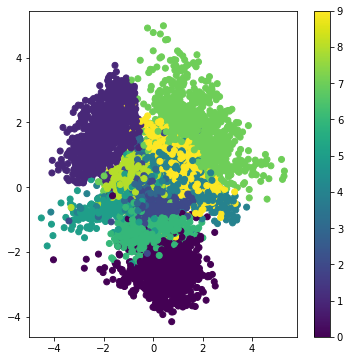

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)  #predicting values in latent space from original image 

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test)
plt.colorbar()
plt.show()


In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

print(figure.shape)


(420, 420)


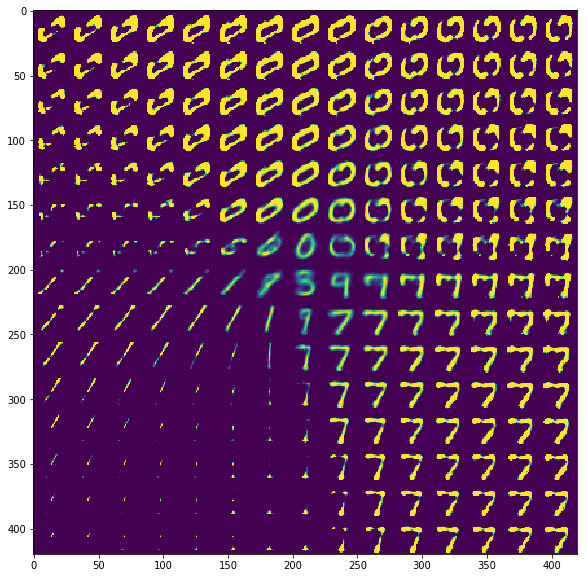

In [ ]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()
